<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Style Transfer

## Objective
To explore an alternative use of DNNs by implementing the style transfer algorithm ([Gatys et. al. 2016](https://arxiv.org/pdf/1508.06576.pdf)).
To understand the importance of a complex loss function.
To see how we can optimize not only over network parameters,
but over other objects (such as images) as well.

## Deliverable
For this lab, you will need to implement the style transfer algorithm of Gatys et al.

* You must extract statistics from the content and style images
* You must formulate an optimization problem over an input image
* You must optimize the image to match both style and content

In your jupyter notebook, you should turn in the following:

* The final image that you generated
* Your code
* A description of the equations from (Gatys et. al. 2016) -- see the bottom of the notebook for details.

An example image that I generated is shown below

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=300&tok=179805&media=cs501r_f2016:style1.png)

## Grading standards
Your code will be graded on the following:

* 35% Correct extraction of statistics
* 35% Correct construction of loss function in a loss class
* 10% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 10% Correct initialization and optimization of image variable
* 10% Awesome looking final image

Note: You may reference other implementations for ideas, but you are on your honor not to copy/paste other people's code.

## Description:

For this lab, you should implement the style transfer algorithm referenced above.
To do this, you will need to unpack the given images.
Since we want you to focus on implementing the paper and the loss function, 
we will give you the code for this.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files

from copy import deepcopy
import re

In [3]:
# Use this code to upload your own images

load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving Abbey Road.jpg to Abbey Road.jpg

Upload Style Image


Saving style image.jpeg to style image.jpeg
Content Path: <_io.BytesIO object at 0x7f4c90f22b80>
Style Path: <_io.BytesIO object at 0x7f4d2eda4950>


In [4]:
# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()


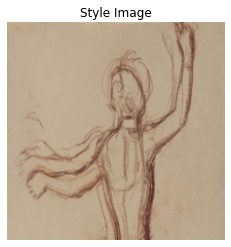

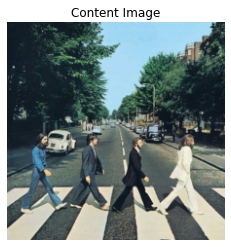

In [6]:
# Display the images
toPIL = transforms.ToPILImage()  

def display(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)    
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.axis('off')

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')


___

### Part 1
Create a class to extract the layers needed for statistics


In [7]:
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
          m.inplace = False          # the model has a hard time going backwards on the in place functions. 
        
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
    
  def forward(self, x):
    self.vgg(self.norm(x))  
    return self.intermediates

___

### Part 2
Create a classes for the style and content loss


In [9]:
def gram_matrix(input):
    n, c, h, w = input.size()
    input = input.view(n*c, h*w)
    
    G = input @ input.T
    G /= n*c*h*w
            
    return G

class ContentLoss(nn.Module):
    def __init__(self, P):
        """
        Input:
        P (tensor): Content Image
        """
        super(ContentLoss, self).__init__()
        self.P = P.detach()
        
    def forward(self, input):
        """
        Input:
        F (tensor): Morphed Image
        """
        self.loss = 0.5 * torch.sum((input - self.P)**2)
        
        return input
    
class StyleLoss(nn.Module):
    def __init__(self, A):
        """
        Input:
        A (tensor): Style_Image
        """
        super(StyleLoss, self).__init__()
        self.A = gram_matrix(A).detach()
        
    def forward(self, input):
        """
        Input:
        F (tensor): Morphed Image
        """
        n,c,h,w = input.size()
            
        G = gram_matrix(input)
        self.loss = (1 / 4*(c**2 * (h * w)**2)) * torch.sum((G - self.A)**2)
        
        return input


___

### Part 3
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?


In [22]:
def get_activations(img, layers):
    # Collect memory from previous operations to free up GPU memory
    gc.collect()

    # Create a VGGIntermediate model with the specified layers
    model = VGGIntermediate(requested=layers).cuda()

    # Pass the image through the model to compute the activations of the specified layers
    model(img)
    return model.intermediates

# Default layers for content and style representations
default_content_layers = ['conv4_1']
default_style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']

def style_transfer(content_img, style_img, steps=5000, style_w=1_000_000, content_w=1,
                   content_layers=default_content_layers, style_layers=default_style_layers):
    # Names of all the layers in the VGG19 model
    layer_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]
    
    # Get the indices of the content and style layers in the list of all layer names
    content_idx = [layer_names.index(name) for name in content_layers]
    style_idx = [layer_names.index(name) for name in style_layers]
    
    # Get the activations of the specified content and style layers for the input images
    content_targets = get_activations(content_img, content_idx)
    style_targets = get_activations(style_img, style_idx)
    
    # Combined indices of content and style layers
    combined_idx = sorted(list(set(content_idx) | set(style_idx)))
    
    # Create a VGGIntermediate model with the combined content and style layers
    model = VGGIntermediate(requested=combined_idx).cuda()
    
    # Create content loss functions for each content layer
    content_loss_fns = { i : ContentLoss(targ) for i, targ in content_targets.items()}
    
    # Create style loss functions for each style layer
    style_loss_fns = { i : StyleLoss(targ) for i, targ in style_targets.items()}

    # Create an Adam optimizer for the content image
    optimizer = optim.Adam([content_img.requires_grad_()])



    # Initialize the iteration counter
    iteration = [0]
    
    # Loop until iteration is less than or equal to the number of steps
    while iteration[0] <= steps:
        # Define the update_loss function
        def update_loss():
            # Clamp the values between 0 and 1 for the content image
            content_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(content_img)

            # Get the intermediate layer outputs of the model
            layer_outputs = model.intermediates

            # Initialize the style and content loss values
            style_loss_values = torch.zeros(len(style_loss_fns)).cuda()
            content_loss_value = 0

            # Calculate the style loss
            for index, (layer, style_loss_func) in enumerate(style_loss_fns.items()):
                style_loss_func(layer_outputs[layer])
                style_loss_values[index] = style_loss_func.loss

            # Calculate the content loss
            for layer, content_loss_func in content_loss_fns.items():
                content_loss_func(layer_outputs[layer])
                temp = content_loss_func.loss
                content_loss_value += temp

            # Calculate the average style loss
            avg_style_loss = style_loss_values.mean() * style_w
            # Multiply the content loss by the weight
            content_loss_value *= content_w

            # Calculate the total loss
            total_loss = avg_style_loss + content_loss_value
            # Perform the backward pass to calculate the gradients
            total_loss.backward()

            iteration[0] += 1
            # Print the current epoch and total loss every 1000 iterations
            if iteration[0] % 1000 == 0:
                print("Epoch: {}".format(iteration[0]))
                print("Total Loss: {:.4f}".format(total_loss))

            # Return the total loss
            return total_loss
        
        optimizer.step(update_loss)
    
    content_img.data.clamp_(0, 1)
    
    # Return the final output image
    return content_img



## First attempt with 2000 epochs

<ipython-input-7-3d6c234280c9>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-7-3d6c234280c9>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Epoch: 50
Average Style Loss: 14658678026393354240.0000 Content Loss: 14863223.0000
Total Loss: 14658678026393354240.0000
Epoch: 100
Average Style Loss: 8266963496701263872.0000 Content Loss: 18032058.0000
Total Loss: 8266963496701263872.0000
Epoch: 150
Average Style Loss: 5741860826478804992.0000 Content Loss: 19709842.0000
Total Loss: 5741860826478804992.0000
Epoch: 200
Average Style Loss: 4382422725751209984.0000 Content Loss: 20810534.0000
Total Loss: 4382422725751209984.0000
Epoch: 250
Average Style Loss: 3538430178566864896.0000 Content Loss: 21602226.0000
Total Loss: 3538430178566864896.0000
Epoch: 300
Average Style Loss: 2966399358611750912.0000 Content Loss: 22205204.0000
Total Loss: 2966399358611750912.0000
Epoch: 350
Average Style Loss: 2551070111213551616.0000 Content Loss: 22685024.0000
Total Loss: 2551070111213551616.0000
Epoch: 400
Average Style Loss: 2233318260172914688.0000 Content Loss: 23093024.0000
Total Loss: 2233318260172914688.0000
Epoch: 450
Average Style Loss: 

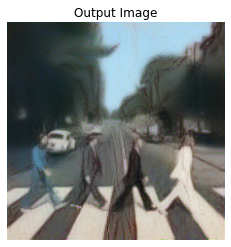

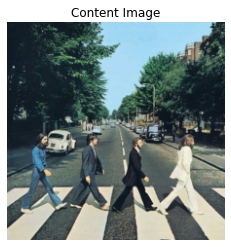

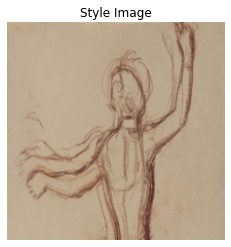

In [17]:
# Start with a copy of the content image
content_copy = deepcopy(content_image).cuda()

output_image = style_transfer(content_copy, style_image)
# Show the image
plt.figure()
display(output_image, title='Output Image')
plt.figure()
display(content_image, title='Content Image')
plt.figure()
display(style_image, title='Style Image')

## Same thing with 10,000 epochs

<ipython-input-7-3d6c234280c9>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-7-3d6c234280c9>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior i

Epoch: 1000
Average Style Loss: 865873721930285056.0000 Content Loss: 25578572.0000
Total Loss: 865873721930285056.0000
Epoch: 2000
Average Style Loss: 402145759383781376.0000 Content Loss: 27205008.0000
Total Loss: 402145759383781376.0000
Epoch: 3000
Average Style Loss: 248065852044214272.0000 Content Loss: 28262196.0000
Total Loss: 248065852044214272.0000
Epoch: 4000
Average Style Loss: 169375540011073536.0000 Content Loss: 29113996.0000
Total Loss: 169375540011073536.0000
Epoch: 5000
Average Style Loss: 121873296206594048.0000 Content Loss: 29814514.0000
Total Loss: 121873296206594048.0000
Epoch: 6000
Average Style Loss: 91416703858114560.0000 Content Loss: 30435124.0000
Total Loss: 91416703858114560.0000
Epoch: 7000
Average Style Loss: 72063512502861824.0000 Content Loss: 30934154.0000
Total Loss: 72063512502861824.0000
Epoch: 8000
Average Style Loss: 59072722491146240.0000 Content Loss: 31265980.0000
Total Loss: 59072722491146240.0000
Epoch: 9000
Average Style Loss: 50243450846576

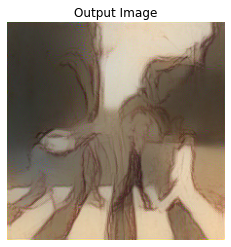

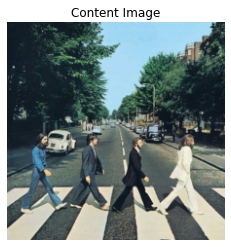

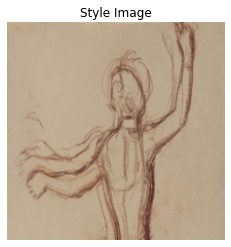

In [21]:
# Start with a copy of the content image
content_copy = deepcopy(content_image).cuda()

output_image = style_transfer(content_copy, style_image, steps=10000)
# Show the image
plt.figure()
display(output_image, title='Output Image')
plt.figure()
display(content_image, title='Content Image')
plt.figure()
display(style_image, title='Style Image')

## Same thing but now using a different style image

Upload Content Image


Saving Abbey Road.jpg to Abbey Road (2).jpg

Upload Style Image


Saving contemporary.jpg to contemporary (1).jpg
Content Path: <_io.BytesIO object at 0x7f4c8009fb30>
Style Path: <_io.BytesIO object at 0x7f4c8917fc20>


<ipython-input-7-3d6c234280c9>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-7-3d6c234280c9>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Epoch: 1000
Total Loss: 7213160216559353856.0000
Epoch: 2000
Total Loss: 3375114218935156736.0000
Epoch: 3000
Total Loss: 2075520337084153856.0000
Epoch: 4000
Total Loss: 1457651564561825792.0000
Epoch: 5000
Total Loss: 1095345646937833472.0000
Epoch: 6000
Total Loss: 845384322746679296.0000
Epoch: 7000
Total Loss: 674869242012631040.0000
Epoch: 8000
Total Loss: 562489189329797120.0000
Epoch: 9000
Total Loss: 492455864918081536.0000
Epoch: 10000
Total Loss: 441446393769361408.0000


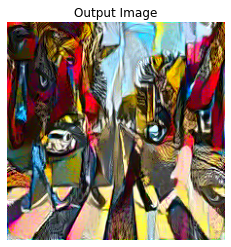

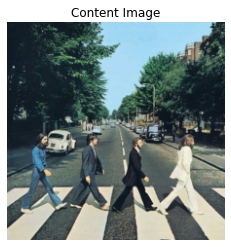

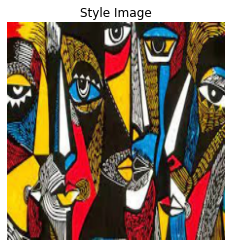

In [25]:
# Use this code to upload your own images

load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))

# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()

# Start with a copy of the content image
content_copy = deepcopy(content_image).cuda()

output_image = style_transfer(content_copy, style_image, steps=10000)
# Show the image
plt.figure()
display(output_image, title='Output Image')
plt.figure()
display(content_image, title='Content Image')
plt.figure()
display(style_image, title='Style Image')

## Another style image

Upload Content Image


Saving Abbey Road.jpg to Abbey Road (3).jpg

Upload Style Image


Saving beret.jpg to beret.jpg
Content Path: <_io.BytesIO object at 0x7f4c891ace50>
Style Path: <_io.BytesIO object at 0x7f4c80089130>


<ipython-input-7-3d6c234280c9>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-7-3d6c234280c9>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Epoch: 1000
Total Loss: 1757034699470929920.0000
Epoch: 2000
Total Loss: 766411419045330944.0000
Epoch: 3000
Total Loss: 457970919663468544.0000
Epoch: 4000
Total Loss: 303146076016214016.0000
Epoch: 5000
Total Loss: 213105556989149184.0000
Epoch: 6000
Total Loss: 156773813906833408.0000
Epoch: 7000
Total Loss: 118670186906648576.0000
Epoch: 8000
Total Loss: 93115011236364288.0000
Epoch: 9000
Total Loss: 76217372943319040.0000
Epoch: 10000
Total Loss: 64527674554449920.0000


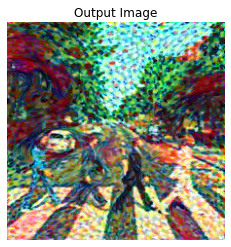

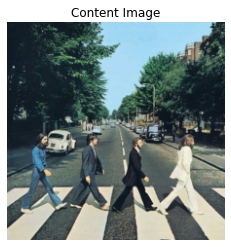

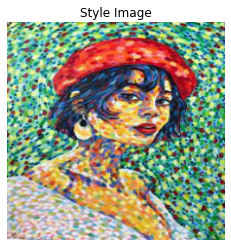

In [26]:

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))

# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()

# Start with a copy of the content image
content_copy = deepcopy(content_image).cuda()

output_image = style_transfer(content_copy, style_image, steps=10000)
# Show the image
plt.figure()
display(output_image, title='Output Image')
plt.figure()
display(content_image, title='Content Image')
plt.figure()
display(style_image, title='Style Image')

## A different content image

Upload Content Image


Saving panda.jpg to panda.jpg

Upload Style Image


Saving contemporary.jpg to contemporary (2).jpg
Content Path: <_io.BytesIO object at 0x7f4c892472c0>
Style Path: <_io.BytesIO object at 0x7f4c80095950>


<ipython-input-7-3d6c234280c9>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-7-3d6c234280c9>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Epoch: 1000
Total Loss: 17977088781416660992.0000
Epoch: 2000
Total Loss: 9114183935146852352.0000
Epoch: 3000
Total Loss: 5576856566742646784.0000
Epoch: 4000
Total Loss: 3741709262699626496.0000
Epoch: 5000
Total Loss: 2648329886149640192.0000
Epoch: 6000
Total Loss: 1943442327431282688.0000
Epoch: 7000
Total Loss: 1459481839105212416.0000
Epoch: 8000
Total Loss: 1126225156126015488.0000
Epoch: 9000
Total Loss: 911759709411737600.0000
Epoch: 10000
Total Loss: 770023039864668160.0000


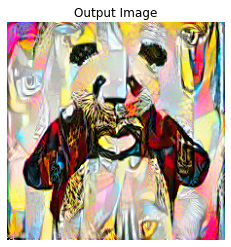

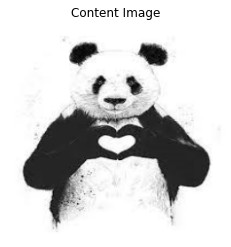

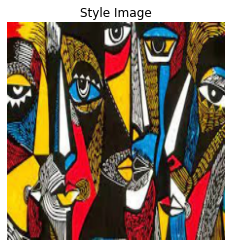

In [27]:

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))

# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()

# Start with a copy of the content image
content_copy = deepcopy(content_image).cuda()

output_image = style_transfer(content_copy, style_image, steps=10000)
# Show the image
plt.figure()
display(output_image, title='Output Image')
plt.figure()
display(content_image, title='Content Image')
plt.figure()
display(style_image, title='Style Image')

## Ok, now I just got carried away playing with different images

Upload Content Image


Saving panda.jpg to panda (1).jpg

Upload Style Image


Saving beret.jpg to beret (1).jpg
Content Path: <_io.BytesIO object at 0x7f4c808ca450>
Style Path: <_io.BytesIO object at 0x7f4c884615e0>


<ipython-input-7-3d6c234280c9>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-7-3d6c234280c9>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Epoch: 1000
Total Loss: 5103129233136287744.0000
Epoch: 2000
Total Loss: 1930805502854299648.0000
Epoch: 3000
Total Loss: 1067838271192563712.0000
Epoch: 4000
Total Loss: 698411160352849920.0000
Epoch: 5000
Total Loss: 487141203666534400.0000
Epoch: 6000
Total Loss: 344644496706764800.0000
Epoch: 7000
Total Loss: 241037000625356800.0000
Epoch: 8000
Total Loss: 169405364263976960.0000
Epoch: 9000
Total Loss: 123430539678973952.0000
Epoch: 10000
Total Loss: 94270331669184512.0000


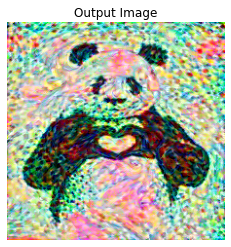

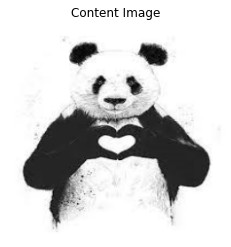

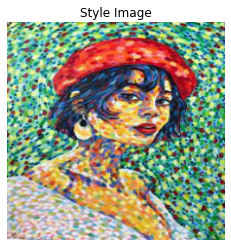

In [28]:

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))

# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()

# Start with a copy of the content image
content_copy = deepcopy(content_image).cuda()

output_image = style_transfer(content_copy, style_image, steps=10000)
# Show the image
plt.figure()
display(output_image, title='Output Image')
plt.figure()
display(content_image, title='Content Image')
plt.figure()
display(style_image, title='Style Image')

### Part 4

- Describe equation (1) on p. 10 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

Equation 1: Describes the CONTENT loss, which measures the difference between the feature representations of the input image and target image in the neural network. The content loss is used to ensure that the input image has similar content to the target image.

Equation 3: Describes the STYLE loss, which measures the difference between the feature correlations of the input image and target style image in the neural network. The style loss is used to ensure that the input image has a similar style to the target style image.

Equation 4: Equation 4 is the total loss function, which is a combination of the content loss and style loss. The total loss is used to optimize the input image so that it has both similar content and style to the target images.

Equation 5: Equation 5 describes the gradient descent optimization algorithm, which is used to minimize the total loss and find the optimal input image that matches the target images. The optimization process updates the pixel values in the input image iteratively until the total loss reaches a minimum.

In summary, equations 1 and 3 define the two types of losses that are used to evaluate the difference between the input and target images, while equation 4 defines the total loss that combines both losses. Equation 5 describes the optimization process that minimizes the total loss and finds the optimal input image.